In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 给定开源数据集enron1；

## 查看下合法邮件和垃圾邮件的内容 

In [3]:
file_path = 'enron1/ham/0007.1999-12-14.farmer.ham.txt'
with open(file_path,'r') as infile:
    ham_sample = infile.read()
print(ham_sample)

Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks


In [4]:
file_path = 'enron1/spam/0058.2003-12-21.GP.spam.txt'
with open(file_path,'r') as infile:
    spam_sample = infile.read()
print(spam_sample)

Subject: stacey automated system generating 8 k per week parallelogram
people are
getting rich using this system ! now it ' s your
turn !
we ' ve
cracked the code and will show you . . . .
this is the
only system that does everything for you , so you can make
money
. . . . . . . .
because your
success is . . . completely automated !
let me show
you how !
click
here
to opt out click here % random _ text



## 初始化变量：从最原始文档，到读取内容，到训练集labels

In [5]:
import glob
import os
emails, labels =[], []
file_path = 'enron1/spam/'
for filename in glob.glob(os.path.join(file_path, '*.txt')):     # 遍历垃圾邮件的文档list
    with open(filename, 'r', encoding = 'ISO-8859-1') as infile:
        emails.append(infile.read())                             # 读取邮件内容，并存入email list
        labels.append(1)                                         # 垃圾邮件的label 指定为1，合法邮件为0

# ham email:
ham_file_path = 'enron1/ham/'
for filename in glob.glob(os.path.join(ham_file_path, '*.txt')):
    with open(filename, 'r', encoding = 'ISO-8859-1') as infile:
        emails.append(infile.read())
        labels.append(0)

## 清洗原始文本数据：

    * 清除数字和标点符号
    * 移除人名（可选）
    * 移除停用词
    * 词形还原

In [6]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

def letters_only(astr):
    return astr.isalpha()

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

# 将上述method 合为一个function 来做文本清洗：

def clean_text(docs): # 参数输入为emails list，每个email是一个document
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower())
                                     for word in doc.split()
                                     if letters_only(word) and word not in all_names]))
    return cleaned_docs

cleaned_emails = clean_text(emails)

移除停用词，提取特征，**向量化**：

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_features=500) # 只考虑最频繁的500 terms；可调整获得更好的accuracy
term_docs = cv.fit_transform(cleaned_emails) # 向量化，将document matrix（rows of words）转换为一个 term document matrix
print(term_docs[0])                          # 每行是一个文档、一份email的词频稀疏向量

  (0, 481)	1
  (0, 357)	1
  (0, 69)	1
  (0, 285)	1
  (0, 424)	1
  (0, 250)	1
  (0, 345)	1
  (0, 445)	1
  (0, 231)	1
  (0, 497)	1
  (0, 47)	1
  (0, 178)	2
  (0, 125)	2



    (row index, feature/term index) 词频      ——该稀疏向量的形式
查看对应的term：

In [8]:
feature_names = cv.get_feature_names()
feature_names[481]  # 上面第一个term
feature_names[357]

'website'

'read'

In [9]:
# 或者查看vocabulary dictionary：{feature: feature_index}
feature_mapping=cv.vocabulary_
#feature_mapping
feature_mapping['read']

357

## 得到term_docs后，就可以建模了，用Naive Bayes model

分别计算prior, 各feature的likelihood, evidence

![naive bayes](nb_model.png)

### 将数据按label分组：

In [10]:
def get_label_index(labels):
    from collections import defaultdict # defaultdict: 若dict 的key不存在时，返回一个默认值
    label_index = defaultdict(list)     # 相当于 label_index ={} 空字典，只不过下面引用key时，若key不存在，则返回值为列表
    for index, label in enumerate(labels):
        label_index[label].append(index)  # test example见下文
    return label_index

In [11]:
d = dict(a=[1,2,3])
d
d['a'].append(4)
d

{'a': [1, 2, 3]}

{'a': [1, 2, 3, 4]}

In [12]:
label_index = get_label_index(labels) # 其实就是ham/spam : 0/1 2组
# 训练样本的indices 按0/1类分组 {0: [3000, 3001, 3002, 3003, ...... 6670, 6671], 1: [0, 1, 2, 3, ...., 2998, 2999]}

### 计算prior：

In [13]:
def get_prior(label_index):
    """Compute prior based on training samples
    Args:
        label_index (grouped sample indices by class)
    Return:
        dictionary, with class label as key, corresponding prior as the value
    """
    prior = {label: len(index_list) for label, index_list in label_index.items()} # {"0":3672,"1":1500}
    total_count = sum(prior.values())  # sum(dict_values([3672,1500]))
    for label in prior:
        prior[label] /= float(total_count)
    return prior

In [14]:
prior = get_prior(label_index)
prior

{0: 0.7099767981438515, 1: 0.2900232018561485}

### 计算likelihood：

In [15]:
import numpy as np

def get_likelihood(term_document_matrix, label_index, smoothing=0):
    """Compute likelihood based on training samples.
    Args:
        term_document_matrix (sparse matrix)
        label_index (grouped sample indices by class)
        smoothing (integer additive Laplace smoothing parameter)
    Returns:
        dictionary, with class as key, corresponding conditional probability P(feature|class) vector as value
    """
    likelihood = {}
    for label, index in label_index.items():
        likelihood[label] = term_document_matrix[index, :].sum(axis=0) + smoothing
        likelihood[label] = np.asarray(likelihood[label])[0]
        total_count = likelihood[label].sum()
        likelihood[label] = likelihood[label] / float(total_count)
    return likelihood

In [16]:
likelihood = get_likelihood(term_docs, label_index, smoothing=1)
len(likelihood[0])

500

### 有了prior 和likelihood，就能计算test／new sample的后验概率：
一个trick：避免连乘导致下溢，取log 变成连加再对结果取e值

In [17]:
def get_posterior(term_document_matrix, prior, likelihood):
    """Computer posterior of testing samples, based on prior and likelihood
    Args:
        term_document_matrix (sparse matrix)
        prior (dictionary, with class label as key, corresponding prior as the value)
        likelihood (dictionary, with class label as key, corresponding conditional probability vector as value)
    Return:
        dictionary, with class label as key, corresponding posterior as value
    """
    num_docs = term_document_matrix.shape[0]
    posteriors = []
    for i in range(num_docs):
        # posterior is proportional to prior * likelihood
        # = exp(log(prior * likelihood))
        # = exp(log(prior) + log(likelihood))
        posterior = {key: np.log(prior_label) for key, prior_label in prior.items()} # prior:{0: 0.7099767981438515, 1: 0.2900232018561485}
        for label, likelihood_label in likelihood.items():
            term_document_vector = term_document_matrix.getrow(i)
            counts = term_document_vector.data
            indices = term_document_vector.indices
            for count, index in zip(counts, indices):
                posterior[label] += np.log(likelihood_label[index]) * count
        # exp(-1000)/exp(-999) 会导致除零错误，但它= exp(0)/exp(1) = exp(-1)
        min_log_posterior = min(posterior.values())
        for label in posterior:
            try:
                posterior[label] = np.exp(posterior[label] - min_log_posterior)
            except:
                # 如果一个log值极大，就设其为无穷大
                posterior[label] = float('inf')
        # normalize so that all sum up to 1
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] /= sum_posterior
        posteriors.append(posterior.copy())
    return posteriors

### 预测new sample:

In [18]:
emails_test = [
    '''Subject: flat screens
    hello ,
    please call or contact regarding the other flat screens requested .
    trisha tlapek - eb 3132 b
    michael sergeev - eb 3132 a
    also the sun blocker that was taken away from eb 3131 a .
    trisha should two monitors also michael .
    thanks
    kevin moore''',
    '''Subject: having problems in bed ? we can help !
    cialis allows men to enjoy a fully normal sex life without having to plan the sexual act .
    if we let things terrify us , life will not be worth living .
    brevity is the soul of lingerie .
    suspicion always haunts the guilty mind .''',
]

cleaned_test = clean_text(emails_test)
term_docs_test = cv.transform(cleaned_test)
posterior = get_posterior(term_docs_test, prior, likelihood)
print(posterior)

[{1: 0.0032745671008375999, 0: 0.99672543289916238}, {1: 0.99999847255388452, 0: 1.5274461154428757e-06}]


第一个邮件是合法邮件，第二个邮件是垃圾邮件

### 模型评估
拆分数据集

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.33, random_state=42)

len(X_train),len(Y_train)
len(X_test), len(Y_test)

(3465, 3465)

(1707, 1707)

In [20]:
term_docs_train = cv.fit_transform(X_train)
label_index = get_label_index(Y_train)
prior = get_prior(label_index)
likelihood = get_likelihood(term_docs_train, label_index, smoothing=1)

term_docs_test = cv.transform(X_test)
posterior = get_posterior(term_docs_test, prior, likelihood)

/Users/linzhun/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in exp


评估：

In [21]:
correct = 0.0
for pred, actual in zip(posterior, Y_test):
    if actual == 1:
        if pred[1] >= 0.5:
            correct += 1
    elif pred[0] > 0.5:   # 可省略 if actual ==0
        correct += 1
print('The accuracy on {0} testing samples is: {1:.1f}%'.format(len(Y_test), correct/len(Y_test)*100))

The accuracy on 1707 testing samples is: 92.0%


### 从头代码实现一个模型，是学习机器学习模型的最好方式。当然，我们也可以走捷径，调用sklearn :

In [22]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True) # 参数：alpha=smoothing；从训练集中学得先验
clf.fit(term_docs_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob[0:10]

array([[  1.00000000e+00,   2.12716600e-10],
       [  1.00000000e+00,   2.72887131e-75],
       [  6.34671963e-01,   3.65328037e-01],
       [  1.00000000e+00,   1.67181666e-12],
       [  1.00000000e+00,   4.15341124e-12],
       [  1.37860327e-04,   9.99862140e-01],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.07066506e-18],
       [  1.00000000e+00,   2.02235745e-13],
       [  3.03193335e-01,   6.96806665e-01]])

In [24]:
prediction = clf.predict(term_docs_test)
prediction[:10]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [25]:
accuracy = clf.score(term_docs_test, Y_test)
print("The accuracy using MultinomialNB is: {0: 1f}%".format(accuracy*100))

The accuracy using MultinomialNB is:  92.032806%


## 除了accuracy，还有其他性能度量，可以防止class imbalance 的影响
    
Confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction,labels=[0,1])

array([[1098,   93],
       [  43,  473]])

In [27]:
accuracy = ((1098+473)/(1098+93+43+473))*100
precision = (473/(93+473))*100   # spam 的 label 是 1
recall = (473/(473+43))*100
F1 = 2*precision*recall/(precision+recall)


print('accuracy: {:.2f}%'.format(accuracy))
print('precision: {:.2f}%'.format(precision)) 
print('recall: {0:.2f}%'.format(recall))
print('F1: {:.2f}%'.format(F1))

accuracy: 92.03%
precision: 83.57%
recall: 91.67%
F1: 87.43%


也可以用sklearn 的函数计算:

In [28]:
from sklearn.metrics import precision_score,recall_score, f1_score

precision_score(Y_test, prediction, pos_label=1)

recall_score(Y_test, prediction, pos_label=1)

f1_score(Y_test, prediction, pos_label=1)

0.83568904593639581

0.91666666666666663

0.87430683918669128

### 一个个算比较麻烦，可以一次性得到以上3个度量的report：

In [29]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

             precision    recall  f1-score   support

          0       0.96      0.92      0.94      1191
          1       0.84      0.92      0.87       516

avg / total       0.92      0.92      0.92      1707



### precision, recall, and f1 score 也可应用于多类别分类，我们可以将一个感兴趣的类视为正类，其他类都作为负类。

# AUC of ROC

## 一个二分类器调参过程中，
如果有一组参数，使得各类的f1_score 和2个类的f1平均分同时达到最高，则是完美的。然而，通常情况并非如此。有时一个模型比另一个模型具有更高的平均f1得分，但对于某个特定的类来说，F1的分数是非常低的；有时两个模型的F1平均得分相同，但一个类的F1得分较高，而另一个类的得分较低。
### 这种情况下，如何评价哪个模型表现更好？
Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) 是二分类器中常用的统一度量。

    ROC曲线是从0到1不等的各种概率阈值下 真阳率与假阳率的关系图。 对于测试样本，如果正类的概率大于阈值，则判定为正类，否则为负。综上所述，真阳率等于recall，假阳率是 负类被错误地鉴定为阳性的占比。

In [30]:
pos_prob = prediction_prob[:,1]
thresholds = np.arange(0.0, 1.2, 0.1)  # 阈值区间为（0.0, 0.1, 0.2, ..., 1.0）
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:   # 真值与预测值均为1
                true_pos[i] += 1
            else:       # 真值为0，预测为1 
                false_pos[i] += 1
        else:
            break
                    

In [31]:
confusion_matrix(Y_test, prediction,labels=[0,1])
# 记得positive有516个，negative有1191个

array([[1098,   93],
       [  43,  473]])

In [32]:
# 计算真阳率和假阳率
true_pos_rate = [tp/516.0 for tp in true_pos]
false_pos_rate = [fp/1191.0 for fp in false_pos ]

(0.0, 1.0)

(0.0, 1.05)

/Users/linzhun/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


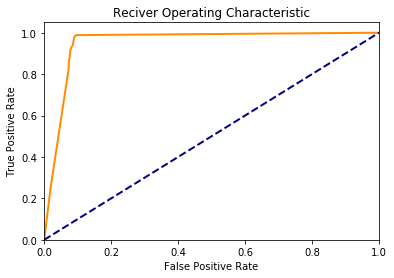

In [33]:
# 作图
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange',lw=lw)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciver Operating Characteristic')
plt.legend(loc='Lower right')
plt.show()

虚线是基线，表示真阳率随假阳率线性增长，其AUC是0.5；
橘红线是模型的ROC图，其AUC稍小于1。

**理想情况下，真阳样本的概率为1，那么ROC的起点是（真阳100%，假阳为0），AUC为1。也就是说，AUC越大越好**

更准确地计算模型的AUC，则可以用sklearn的
    
    roc_auc_score

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.95828777198497783

# 模型调优和K折交叉验证
学习了衡量分类模型的度量标准，我们现在可以研究如何正确地度量它。我们不能只采用一个固定测试集的分类结果，我们通常采用k 折交叉验证。

![k-fold_cv.png](k_fold_cv.png)

给定与机器学习模型相关的不同参数集，模型调优或模型选择的目标是，从中选一组参数，使得平均性能最好。

下面，使用交叉验证和ROC的AUC度量 相结合的朴素贝叶斯分类器

#### 初始化一个10折生成器：

In [39]:
from sklearn.model_selection import StratifiedKFold
k = 10
k_fold = StratifiedKFold(n_splits=k)   # 可用方法 k_fold.split
cleaned_emails_np = np.array(cleaned_emails)
labels_np = np.array(labels)

接下来探索朴素贝叶斯模型中以下参数的值：

    max_features:特征空间中，词频最高的前n个
    smoothing facoter:平滑因子，一个词的初始计数“ the initial count for a term
    是否对训练数据使用给定的先验


In [43]:
max_features_option = [2000, 4000, 8000]
smoothing_factor_option = [0.5, 1.0, 1.5, 2.0]
fit_prior_option = [True, False]
auc_record = {}

In [44]:
for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
    Y_train, Y_test = labels_np[train_indices], labels_np[test_indices]
    for max_features in max_features_option:
        if max_features not in auc_record:
            auc_record[max_features] = {}
        cv = CountVectorizer(stop_words="english", max_features=max_features)
        term_docs_train = cv.fit_transform(X_train)
        term_docs_test = cv.transform(X_test)
        for smoothing_factor in smoothing_factor_option:
            if smoothing_factor not in auc_record[max_features]:
                auc_record[max_features][smoothing_factor] = {}
            for fit_prior in fit_prior_option:
                clf = MultinomialNB(alpha=smoothing_factor, fit_prior=fit_prior)
                clf.fit(term_docs_train, Y_train)
                prediction_prob = clf.predict_proba(term_docs_test)
                pos_prob = prediction_prob[:, 1]
                auc = roc_auc_score(Y_test, pos_prob)
                auc_record[max_features][smoothing_factor][fit_prior] = auc + auc_record[max_features][smoothing_factor].get(fit_prior, 0.0)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=False)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=2.0, class_prior=None, fit_prior=False)

In [53]:
auc_record

{2000: {0.5: {False: 9.7436871865497761, True: 9.7443415077202538},
  1.0: {False: 9.725047017533468, True: 9.7260735793547362},
  1.5: {False: 9.7150178691308291, True: 9.7146733206965994},
  2.0: {False: 9.7067473245666012, True: 9.7061121806263078}},
 4000: {0.5: {False: 9.814603892706236, True: 9.8169451931050808},
  1.0: {False: 9.7971726789874829, True: 9.7966736514236068},
  1.5: {False: 9.7867588753307277, True: 9.7852067784227774},
  2.0: {False: 9.7786787702878808, True: 9.7782340905500913}},
 8000: {0.5: {False: 9.8547581743869213, True: 9.8562751747423292},
  1.0: {False: 9.8452710974213158, True: 9.8453806322315689},
  1.5: {False: 9.8411423903171027, True: 9.8407520337242822},
  2.0: {False: 9.8378716729850328, True: 9.8373451012913176}}}

In [55]:
print('max features smoothing fit prior     auc')
for max_features, max_feature_record in auc_record.items():
    for smoothing, smoothing_record in max_feature_record.items():
        for fit_prior, auc in smoothing_record.items():
            print('    {0}        {1}        {2}      {3:.4f}'.format(max_features,smoothing,fit_prior,auc/k))

max features smoothing fit prior     auc
    2000        0.5        True      0.9744
    2000        0.5        False      0.9744
    2000        1.0        True      0.9726
    2000        1.0        False      0.9725
    2000        1.5        True      0.9715
    2000        1.5        False      0.9715
    2000        2.0        True      0.9706
    2000        2.0        False      0.9707
    4000        0.5        True      0.9817
    4000        0.5        False      0.9815
    4000        1.0        True      0.9797
    4000        1.0        False      0.9797
    4000        1.5        True      0.9785
    4000        1.5        False      0.9787
    4000        2.0        True      0.9778
    4000        2.0        False      0.9779
    8000        0.5        True      0.9856
    8000        0.5        False      0.9855
    8000        1.0        True      0.9845
    8000        1.0        False      0.9845
    8000        1.5        True      0.9841
    8000        1.5      

(8000,0.5,True)参数集 能产生最优AUC 0.9856